In [ ]:
# If running notebook on brainlife, use ! due to version issues
# !pip install llvmlite --ignore-installed # added due to issue with (un)installing correct version
# !pip install git+https://github.com/JulioAPeraza/gradec.git

In [1]:
import itertools
import os.path as op
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gradec.decode import LDADecoder
from gradec.utils import _rm_medial_wall, _decoding_filter
from gradec.plot import plot_surf_maps, plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
import nibabel as nib

### Determine tract names given a data folder with cortical surface termination maps - Change Threshold as Needed

In [7]:
# Path to cortical surface termination maps
threshold = '0' # MODIFY THRESHOLD TO 0.15, 0.25, ETC...
data_dir = op.join(".", "data")
endpt_dir = op.join(
    data_dir, 
    "white-matter-atlas_thresholds", 
    f"cortexmap_binarize_smooth-surf-1_threshold-{threshold}_dilate-0", 
    "cortexmap", 
    "func",
)

# extract all .gii file names
file_names = []
for f in os.listdir(endpt_dir):
    if f.endswith(".gii"):
        file_names.append(f)

tracts_names = [] # all tract names differeniating between left and right tract (ex. left CST and right CST treated as 2 tracts)

# extract tract name from file name
for i in file_names:
    if ("rh.left" in i) or ("lh.right" in i) or ('spino' in i) or ('Cerebellar' in i):
        continue # exclude if file name "rh.left..." or "lh.right..." or spinal/cerebellar tracts
    else:
        tracts_names.append(i.split("_")[0][len('rh.'):])

ALL_TRACT_NAMES = sorted(list(set(tracts_names)))

### Define space, density and paths to data

In [9]:
SPACE, DENSITY = "fsaverage", "164k"
DSET, MODEL = "neuroquery", "lda"

# data_dir = op.join(".", "data") # duplicate from code above
neuromaps_dir = op.join(data_dir, "neuromaps")
figures_dir = op.join(data_dir, "figures")

# List of posssible combinations of tracts, end points and smoothing
tracts = ALL_TRACT_NAMES
endpts = ["RAS", "LPI"]
#tracts = ["Arc", "SLF1And2", "CST"]
#smths = ["", ".smooth_1"]
#thresholds = ["0", "0.15", "0.25"]

# Dictionaries for the title of the figures
TRACTS_DICT = dict(zip(ALL_TRACT_NAMES, ALL_TRACT_NAMES)) # need to eventually change
SMTHS_DICT = {
    "": "Unsmoothed",
    ".smooth_1": "Smoothed",
}
ENDPOINTS_DICT = { 
    "LPI": "Left-Posterior-Inferior",
    "RAS": "Right-Anterior-Superior",
}

### Train and LDA-based decoder on NeuroQuery detabase 

In [12]:
decode = LDADecoder(space=SPACE, density=DENSITY, calc_pvals=False, data_dir=data_dir)
decode.fit(DSET)

# Load features for analysis or visualization
features = _fetch_features(DSET, MODEL, data_dir=data_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=data_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=data_dir)

### Define functions to run decoder

In [10]:
def load_maps_per_tract(endpt_dir, tract):
    """
    This function loads maps when running analysis per tract (leftCST and rightCST = 2 tracts)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): full name of tract (ex. can include whether tract is 'left' or 'right' tract)

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if 'left' in tract:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
    elif 'right' in tract:
        map_lpi_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
    else: # if mono tract
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
        
    return map_arr_lh, map_arr_rh

In [11]:
def load_combined_maps(endpt_dir, tract, isMono):
    """
    This function loads maps when running analysis for combined endpoint ROIs (RAS+LPI)

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    if isMono:
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_arr_rh = nib.load(map_ras_rh).agg_data()
    else: # if bi tracts
        # file names
        map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
        map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
        map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
        map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
        map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
        map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
        map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
        map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
        
    return map_arr_lh, map_arr_rh

In [ ]:
def load_mono_maps(endpt_dir, tract, method=""):   ### MATCH-CASE DOES NOT WORK IN OLDER VERSION OF PYTHON
    """
    This function loads maps when running analysis for mono tracts, separated.
    Can be separated by hemisphere (lh vs. rh) or endpoint ROI (LPI vs. RAS). Functionally, these two are the same.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    isMono (binary): 1 = tract is mono. 0 = tract is bi 

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match method:
        case "lh": # separated by lh or LPI
            map_arr_lh = nib.load(map_lpi_lh).agg_data()
            map_arr_rh = np.zeros_like(map_arr_lh) # load blank right hemisphere
        case "rh": # separated by rh or RAS
            map_arr_rh = nib.load(map_ras_rh).agg_data()
            map_arr_lh = np.zeros_like(map_arr_rh) # load blank left hemisphere
        case _: # default
            print("Error: No separation method provided.")
    
    return map_arr_lh, map_arr_rh

In [ ]:
def load_bi_maps(endpt_dir, tract, splitby="", endpt="", hemisphere=""):  ### MATCH-CASE DOES NOT WORK IN OLDER VERSION OF PYTHON
    """
    This function loads maps when running analysis for bi tracts, separated.
    Can be separated by hemisphere (lh vs. rh), endpoint ROI (LPI vs. RAS), or both.

    Parameters
    endpt_dir (str): file directory where the white matter end point atlases are stored
    tract (str): name of tract
    splitby (str): method of splitting. Can split by "roi", "hem", or "both"
    endpt (str): optional- endpoint ROI. "RAS" or "LPI"
    hemisphere (str): optional- hemisphere. "lh" or "rh"

    Returns
    map_arr_lh (1D array): white matter probability map for left hemisphere
    map_arr_rh (1D array): white matter probability map for right hemisphere
    """
    LH = "lh" # left hemisphere
    RH = "rh" # right hemisphere
    LPI = "LPI" # endpoint ROI: left-posterior-inferior
    RAS = "RAS" # endpoint ROI: right-anterior-superior

    # all file names
    map_lpi_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_lpi_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_LPI_FiberEndpoint.func.gii")
    map_ras_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_RAS_FiberEndpoint.func.gii")
    map_ras_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_RAS_FiberEndpoint.func.gii")

    match splitby:
        case "roi": # separated by endpoint ROI
            if endpt == LPI: 
                map_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_arr_rh = nib.load(map_lpi_rh).agg_data()
            elif endpt == RAS:
                map_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_rh = nib.load(map_ras_rh).agg_data()
            else:
                print("Error: Can't separate by endpoint ROI. Wrong ROI provided.")
        case "hem": # separated by hemisphere
            if hemisphere == LH:
                map_lpi_arr_lh = nib.load(map_lpi_lh).agg_data()
                map_ras_arr_lh = nib.load(map_ras_lh).agg_data()
                map_arr_lh = np.maximum(map_lpi_arr_lh, map_ras_arr_lh) # Take the maximum to address overlap
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_lpi_arr_rh = nib.load(map_lpi_rh).agg_data()
                map_ras_arr_rh = nib.load(map_ras_rh).agg_data()
                map_arr_rh = np.maximum(map_lpi_arr_rh, map_ras_arr_rh) # Take the maximum to address overlap
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere 
            else:
                print("Error: Can't separate by hemisphere. Wrong hemisphere provided.")
        case "both": # separated by enpoint ROI and hemisphere
            if hemisphere == LH:
                map_lh = op.join(endpt_dir, f"lh.left{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_lh = nib.load(map_lh).agg_data()
                map_arr_rh = np.zeros_like(map_arr_lh) # load empty right hemisphere
            elif hemisphere == RH:
                map_rh = op.join(endpt_dir, f"rh.right{tract}_box_1mm_{endpt}_FiberEndpoint.func.gii")
                map_arr_rh = nib.load(map_rh).agg_data()
                map_arr_lh = np.zeros_like(map_arr_rh) # load empty left hemisphere
            else:
                print("Error: Can't separate by endpoint ROI and hemisphere. Incorrect ROI or hemisphere provided.")
        case _: # default
            print("Error: Incorrect separation method provided.")
 
    return map_arr_lh, map_arr_rh

### Clustering: Run decoder for each tract 

In [13]:
tracts_to_analyze = ALL_TRACT_NAMES # modify to just run a few tracts
map_corr_df = pd.DataFrame(columns=['ROI', 'topic', 'r']) # 104 topics*33 ROIs data table in long form

d = {}
for tract in tracts_to_analyze:
    # Read map
    l = []
    map_arr_lh, map_arr_rh = load_maps_per_tract(endpt_dir, tract)

    # Remove medial wall
    map_arr = _rm_medial_wall(
        map_arr_lh,
        map_arr_rh,
        space=SPACE,
        density=DENSITY,
        neuromaps_dir=neuromaps_dir,
    )

    for i in map_arr:   ### maps_arr has the endpoint probabilities
        if i != 0:   ### mark any probability that isn't 0 as 1
            i = 1
        l.append(i)

        # Decode map and calculate correlation of activation map and white matter termination map
    temp_corrs_df = decode.transform([map_arr], method="correlation") # vertex-wise Pearson's r

    # filter to keep only the function-related topics
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        temp_corrs_df,
        features,
        classification,
        pos_corr = False,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )

    # transform and concat into single df for clustering
    filtered_df = filtered_df.rename(columns={0: 'r'})
    sorted_df = filtered_df.sort_values(by="r", ascending=False)
    map_corr_df = pd.concat([map_corr_df, 
                             pd.DataFrame({'ROI': f"{tract}",
                                           'topic': sorted_df.index, 
                                           'r': sorted_df['r']})], 
                                           ignore_index=True)
        
    d[tract] = l
dat = pd.DataFrame(d)     ### dataframe shows if there is a non-zero probability of tract ending in vertex (0-no probability, 1-non-zero probability), vertex vs tract
dat['sum'] = dat.sum(axis = 1)  ### summed to see how many tracts end in one same vertix
        

  0%|          | 0/1 [00:00<?, ?it/s]


### Tracts in Same Vertex - Visualization

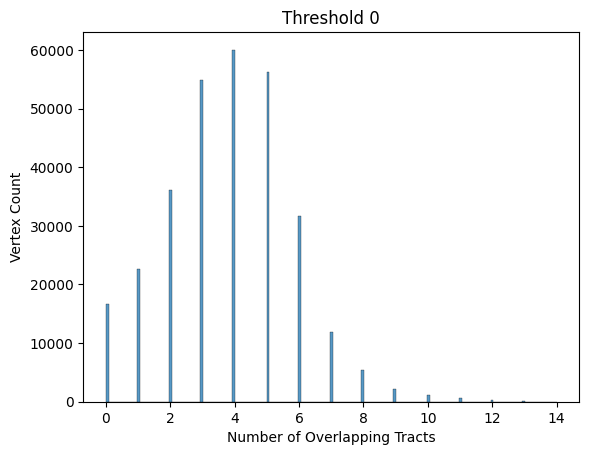

In [17]:
sns.histplot(dat['sum'])
title = 'Threshold ' + threshold
plt.title(title)
plt.xlabel('Number of Overlapping Tracts')
plt.ylabel('Vertex Count');

### Creating Complete Dataframe With Proportion Similarity: Tract vs Tract

In [ ]:
sim_dat = pd.DataFrame(index=dat.columns, columns = dat.drop('sum', axis = 1).columns)
plot_sim = []
for col1 in dat:
    den = dat[col1].sum()
    for col2 in dat:
        num = 0
        for row in range(dat.shape[0]):
            if dat[col1][row] != 0 and (dat[col1][row] == dat[col2][row]) :
                num += 1
        sim = num/den
        plot_sim.append(sim)
        sim_dat.loc[col2,col1] = sim
sim_dat = sim_dat.drop('sum').drop('sum', axis = 1)
sim_dat = sim_dat.astype(float)


### Tract by Tract Similarity Proportion - Visualizations

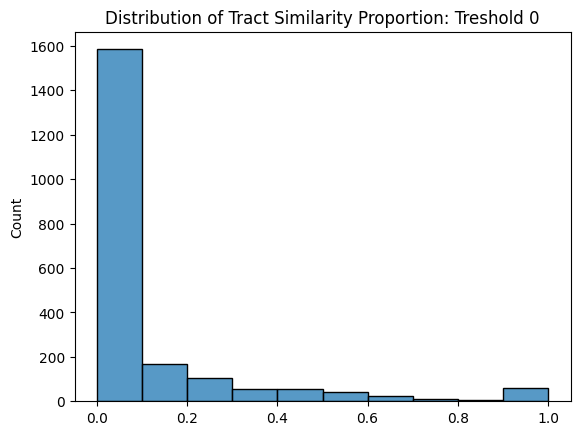

In [21]:
sns.histplot(plot_sim, bins = 10)
title = 'Distribution of Tract Similarity Proportion: Treshold ' + threshold
plt.title(title);

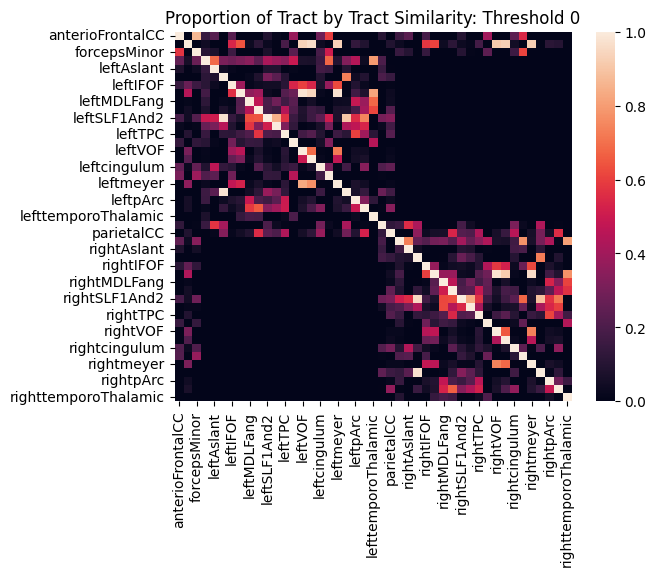

In [24]:
sns.heatmap(sim_dat)
title = 'Proportion of Tract by Tract Similarity: Threshold ' + threshold
plt.title(title);

### Brain Map Surface Covered by Tracts

In [25]:
test_dat = pd.concat([dat,(dat.sum()/299880).to_frame().T], ignore_index = True)  ### last row contains relevant info

#### Checks for 15% requirement

In [27]:
coverage_proportions = (dat.drop('sum', axis = 1).sum()/299881)

# Apply the condition and filter the columns
filtered_tracts = coverage_proportions[coverage_proportions > 0.15]

# Print the tracts that meet the condition
print(filtered_tracts)
print('Number of Tracts:', len(filtered_tracts))

leftArc          0.183876
leftSLF1And2     0.213888
parietalCC       0.150350
rightArc         0.167236
rightSLF1And2    0.211404
dtype: float64
Number of Tracts: 5


#### Checks for 10,000 vertices requirement

In [28]:
num_ver = dat.drop('sum', axis = 1).sum()
filtered_tracts = num_ver[num_ver >= 10000]
print(filtered_tracts)
print('Number of Tracts:', len(filtered_tracts))

anterioFrontalCC        32777.0
forcepsMajor            44166.0
forcepsMinor            21883.0
leftArc                 55141.0
leftAslant              11115.0
leftCST                 20122.0
leftIFOF                21958.0
leftILF                 30932.0
leftMDLFang             19114.0
leftMDLFspl             18162.0
leftSLF1And2            64141.0
leftSLF3                38832.0
leftTPC                 23305.0
leftUncinate            11962.0
leftVOF                 14552.0
leftbaum                10373.0
leftcingulum            30131.0
leftfrontoThalamic      16848.0
leftmeyer               16743.0
leftmotorThalamic       26950.0
leftpArc                19320.0
leftparietoThalamic     29194.0
middleFrontalCC         41911.0
parietalCC              45087.0
rightArc                50151.0
rightAslant             11396.0
rightCST                17727.0
rightIFOF               19606.0
rightILF                31375.0
rightMDLFang            19125.0
rightMDLFspl            20880.0
rightSLF

### Surface Covered by Tracts - Visualization

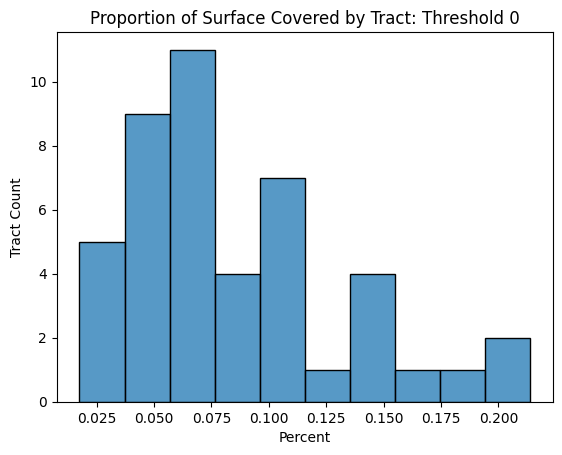

In [29]:
import seaborn as sns
sns.histplot((dat.drop('sum',axis = 1).sum()/299881), bins = 10)
plt.xlabel('Percent')
plt.ylabel('Tract Count')
title = 'Proportion of Surface Covered by Tract: Threshold ' + threshold
plt.title(title);